# MP/BME 573: Homework Set 5 - Handout

In [2]:
## MP 573 HW5 
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd

font = {'weight' : 'normal',
        'size'   : 20}

In [3]:
# Here we define the matrices and vectors relevant to our quadrativ optimization. 
# Note that the correct choice of the diagonal matrix C needs to be uncommented, 
# depending on which version of the problem we are trying to solve
A = np.array([[1, 2, 3], [0, 2, 1], [4, 0, 1]])
    
C = np.diag([400,20,1])
# C = np.diag([20,20,20]) # Uncomment 
    
Q = (A.T).dot(C.dot(A))
    
b = np.array([[100], [100], [100]])


In [4]:
# This function calculates the cost function, its gradient vector, and its Hessian matrix
# for the kind of quadratic function used in this homework set. 
def evalGradients(x, Q, b):

    f = 0.5*(x.T).dot(Q.dot(x)) - (x.T).dot(b)

    g = Q.dot(x) - b
    
    H = Q
       
    return f,g,H


Algorithm: Steepest Descent
Done. Cost function value:
[[7982914.5]]
Final estimate xhat:
[[ 100]
 [   0]
 [-100]]


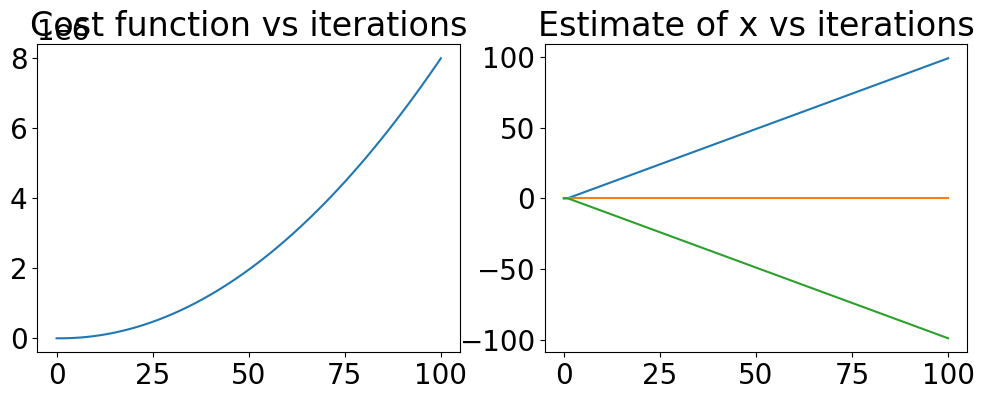

In [18]:
print('Algorithm: Steepest Descent')
x = np.array([[0],[0],[0]]) # Initialize
f,g,H = evalGradients(x, Q, b) # Evaluate cost and gradient (and Hessian, although we don't use it here)
allx = x # Keep track of all the estimates throughout our iterations
allf = f # Keep track of the cost function throughout our iterations
niter = 100 # Max number of iterations
for k in range(0,niter):
    f,g,H = evalGradients(x, Q, b) # Evaluate cost and gradient
    if la.norm(g)>0.000001: # If the gradient is not tiny (ie: if not converged yet)
        d = ([[1], [0], [-1]]) # To-do: replace with the actual direction in SD       
        alpha = 1; # To-do: replace with the actual step size in SD, eg: using line search 
        allx = np.concatenate((allx,x),axis=1) # Update our array of estimates
        allf = np.concatenate((allf,f),axis=1) # Update our array of cost values
        x = x +alpha*d; # Update our current estimate
              
# Display results    
print('Done. Cost function value:')
print(f)
print('Final estimate xhat:')
print(x)

# Plot evolution of our estimates    
plt.figure(figsize=(12,4))
plt.rc('font', **font)
plt.subplot(1,2,1)
plt.plot(allf.T)
plt.title('Cost function vs iterations')
plt.subplot(1,2,2)
plt.plot(allx.T);
plt.title('Estimate of x vs iterations');

Algorithm: Conjugate Gradients
Done. Cost function value:
[[8145000.]]
Final estimate xhat:
[[ 100]
 [   0]
 [-100]]


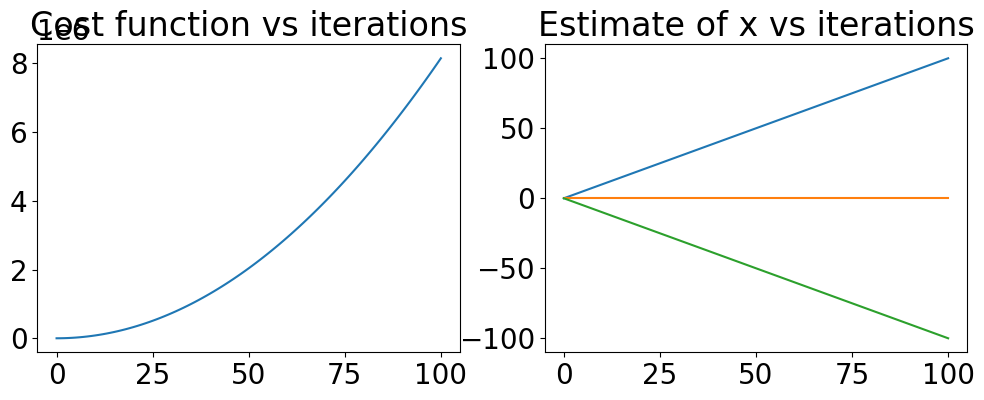

In [21]:
print('Algorithm: Conjugate Gradients')
x = np.array([[0],[0],[0]]) # Initialize
f,g,H = evalGradients(x, Q, b) # Calculate cost and gradient
allx = x
allf = f
niter = 100
if la.norm(g)>0.000001: # If gradient is not tiny, proceed
    d = -g # Set direction
    k=0; # Initialize CG
    while k < niter: # CG iterations
        d = ([[1], [0], [-1]]) # To-do: replace with the actual direction in CG       
        alpha = 1; # To-do: replace with the actual step size in CG
        x = x + alpha*d; # Update estimate
        f,g,H = evalGradients(x, Q, b) # Evaluate cost and gradient
        allx = np.concatenate((allx,x),axis=1) # Keep track of all our estimates
        allf = np.concatenate((allf,f),axis=1) # Keep track of all our cost function values
        k = k+1
        
# Print results    
print('Done. Cost function value:')
print(f)
print('Final estimate xhat:')
print(x)

# Plot evolution of our estimates  
plt.figure(figsize=(12,4))
plt.rc('font', **font)
plt.subplot(1,2,1)
plt.plot(allf.T)
plt.title('Cost function vs iterations')
plt.subplot(1,2,2)
plt.plot(allx.T);
plt.title('Estimate of x vs iterations');


Algorithm: Newton
Done. Cost function value:
[[0.]]
Final estimate xhat:
[[0]
 [0]
 [0]]


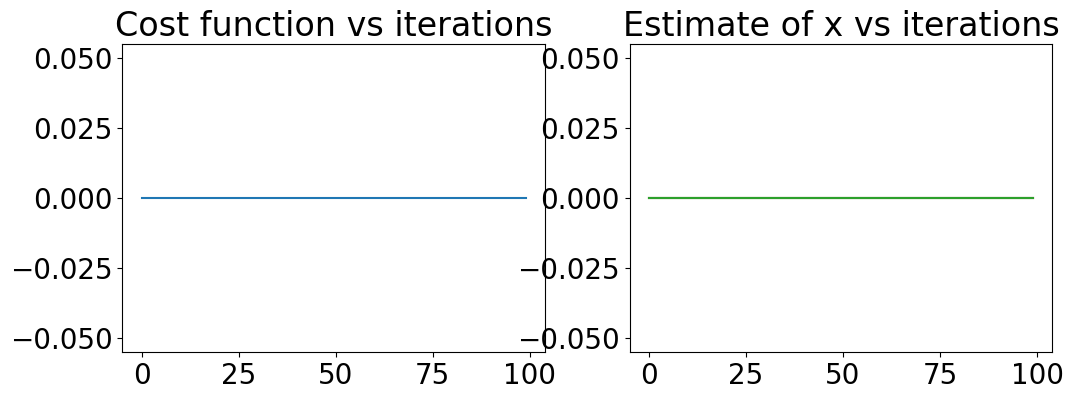

In [22]:
print('Algorithm: Newton')
x = np.array([[0],[0],[0]]) # Initialize
f,g,H = evalGradients(x, Q, b) # Calculate cost, gradient, and Hessian
niter = 100
k = 0
while k < niter: # Newton iterations
    f,g,H = evalGradients(x, Q, b) # Calculate cost, gradient, and Hessian (although we don't use the cost)
    if k == 0:
        allx = x
        allf = f
    else:
        allx = np.concatenate((allx,x),axis=1)
        allf = np.concatenate((allf,f),axis=1)        
        
        
    # To-do: Need to include the actual Newton iteration to update x 
    
    k=k+1    
    
# Print results    
print('Done. Cost function value:')
print(f)
print('Final estimate xhat:')
print(x)

# Plot evolution of our estimates  
plt.figure(figsize=(12,4))
plt.rc('font', **font)
plt.subplot(1,2,1)
plt.plot(allf.T)
plt.title('Cost function vs iterations')
plt.subplot(1,2,2)
plt.plot(allx.T);
plt.title('Estimate of x vs iterations');


